# Ames House Price Data - Extreme Random Forest

> Juptyer notebook, running a Julia 0.5.2 kernel, with the help of Machine Learning modules written by the author

*We build an extreme random forest using the 12 most important features.*

Estimated 95% confidence interval for log-RMS error of Sale Price predictions for the tuned model: 

    0.143 ± 0.019

## Reading in and transforming  the data
Our extreme random forest regressors are constructed in the same way as regular random forests, but with different parameters settings. Once again the input data should be converted to a `TreeCollections.DataTable` object.

In [ ]:
push!(LOAD_PATH, pwd()) # Allow loading of modules from current directory 
addprocs(3) # for parallel processing
using Regressors, Preprocess, Validation
import DataFrames: DataFrame, readtable, writetable
import TreeCollections.DataTable

df = readtable("2.cleaned/train_randomized.csv")
important_features = convert(Array{Symbol}, readtable("3.important_features/important_features.csv")[1])
important_features = important_features[1:12]
const X = DataTable(df[important_features])
const y = collect(df[:target]);

In [2]:
xtreme = BaggedRegressor(atom=TreeRegressor(extreme=true), n = 200, bagging = 0.0)

unfitted BaggedRegressor{Regressors.TreeRegressor}@...9350

## Determining number of iterations for convergence

In [3]:
train, valid = split_bag(1:length(y), 70)

([1,2,3,4,5,6,7,8,9,10  …  1010,1011,1012,1013,1014,1015,1016,1017,1018,1019],[1020,1021,1022,1023,1024,1025,1026,1027,1028,1029  …  1447,1448,1449,1450,1451,1452,1453,1454,1455,1456])

In [4]:
u,v=learning_curve(xtreme, X, y, train, valid, 1:6:300, parallel=true, verbose=false)

([1.0,7.0,13.0,19.0,25.0,31.0,37.0,43.0,49.0,55.0  …  241.0,247.0,253.0,259.0,265.0,271.0,277.0,283.0,289.0,295.0],[0.20564,0.154077,0.152936,0.151097,0.151283,0.150229,0.149946,0.149222,0.14908,0.149433  …  0.148201,0.148384,0.148242,0.14821,0.14803,0.147897,0.148029,0.14799,0.147859,0.147947])


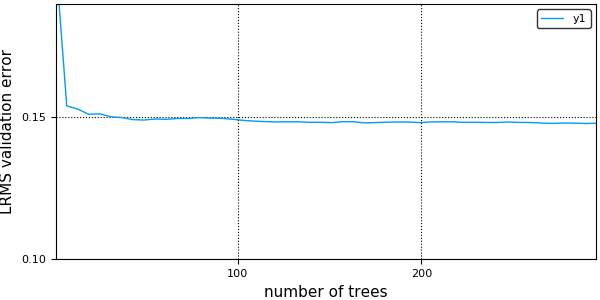

In [5]:
using Plots; pyplot(size=(600,300))
plot(u,v, ylim=(0.1,0.19), xlab="number of trees", ylab="LRMS validation error")

## Tuning `min_patterns_split`
Sometimes increasing the value of `min_patterns_split` above the default value of 2 improves the accuracy of extreme random forests.

In [6]:
full = vcat(train, valid)
u,v = @getfor σ [2,3,4,5,6,7,8,9,10] rms_error(BaggedRegressor(X, y, train;
        atom=TreeRegressor(extreme=true, min_patterns_split=σ), 
        n=200, bagging=0.0, parallel=true, verbose=false), X, y, valid)

([2,3,4,5,6,7,8,9,10],[0.148836,0.146509,0.148063,0.146877,0.147592,0.147374,0.149055,0.147614,0.148349])


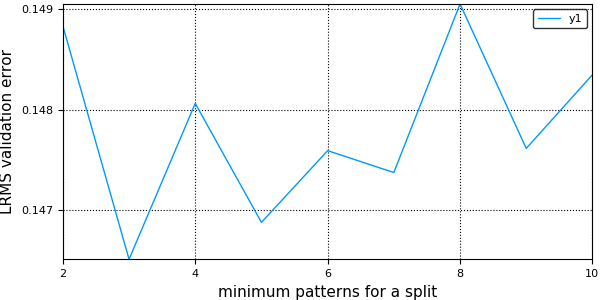

In [7]:
plt=plot(u,v, xlab="minimum patterns for a split", ylab="LRMS validation error")

We'll make several more runs to get an idea of variability:


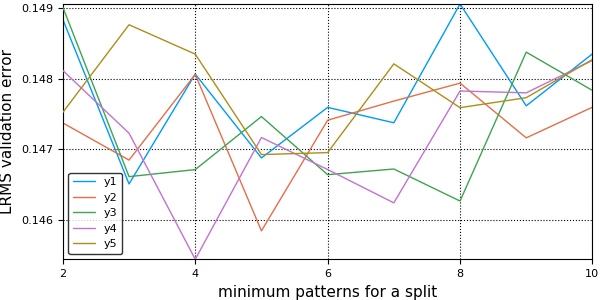

In [8]:
for _ in 1:4
    u,v = @getfor σ [2,3,4,5,6,7,8,9,10] rms_error(BaggedRegressor(X, y, train;
        atom=TreeRegressor(extreme=true, min_patterns_split=σ), 
        n=200, bagging=0.0, parallel=true, verbose=false), X, y, valid)
    plot!(u,v)
end
plt

Probably overkill, given small changes in error (<2%) but we will go ahead and fine tune with cross-validation:

In [9]:
u,v = @getfor σ [4,6,7,8] cv_error(
    BaggedRegressor(atom=TreeRegressor(extreme=true, min_patterns_split=σ), 
        n=400, bagging=0), X, y, full; n_folds=6, verbose=false, parallel=true)

([4,6,7,8],[0.145834,0.145074,0.145242,0.145401])


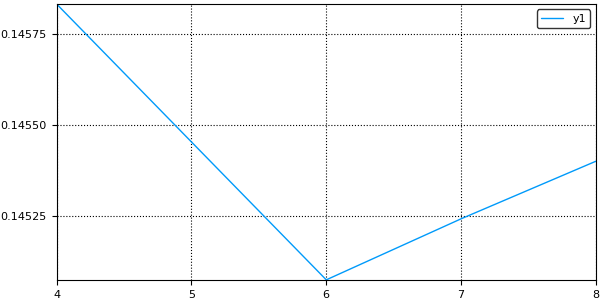

In [10]:
plot(u,v)

## Cross-validation of tuned model

In [11]:
xtreme = BaggedRegressor(atom=TreeRegressor(extreme=true, min_patterns_split=6), 
    n = 200, bagging = 0)
errors_xtreme = cv_errors(xtreme, X, y, full;
    n_folds=12, verbose=false, parallel=true)


12-element Array{Float64,1}:
 0.149956
 0.159235
 0.147025
 0.113199
 0.159776
 0.13187 
 0.131168
 0.144694
 0.122462
 0.159655
 0.121659
 0.172558

Approximate 95% confindence interval for RMSL error of model's prediction of Sale Prices:

In [12]:
string(mean(errors_xtreme), " ± ", std(errors_xtreme))


"0.1427712906276908 ± 0.018567184245796505"

## Appending cross-validation errors to file

In [13]:
using JLD
file = jldopen("cv_errors.jld", "r+") # read/append mode
write(file, "errors_xtreme", errors_xtreme)
close(file)

In [14]:
d=load("cv_errors.jld")

Dict{String,Any} with 3 entries:
  "errors_reg"    => [0.158303,0.188096,0.156075,0.131025,0.176282,0.163463,0.1…
  "errors_rf"     => [0.140843,0.157592,0.137208,0.104009,0.162211,0.139515,0.1…
  "errors_xtreme" => [0.149956,0.159235,0.147025,0.113199,0.159776,0.13187,0.13…